In [1]:
import pandas as pd
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
%matplotlib inline

In [2]:
df = pd.read_csv("../Data/NYCTaxiFares.csv")
df.head(10)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1
5,2010-04-22 08:39:47 UTC,8.1,0,-73.980481,40.748995,-73.983508,40.766459,1
6,2010-04-23 19:27:00 UTC,4.9,0,-73.959535,40.779582,-73.947185,40.780223,1
7,2010-04-15 09:03:37 UTC,4.9,0,-74.002601,40.739419,-73.997912,40.730292,1
8,2010-04-20 08:58:00 UTC,2.9,0,-74.014005,40.704058,-74.013202,40.702877,1
9,2010-04-16 18:50:16 UTC,6.1,0,-73.977689,40.784175,-73.988639,40.778669,1


In [3]:
df.shape

(120000, 8)

In [3]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [4]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [5]:
#converting to datetime object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [6]:
df.head(5)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [7]:
#adjust the date and time to match eastern time
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']>12, 'am', 'pm')
df.head(10)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,pm
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,pm
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,pm
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,am
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,am
5,2010-04-22 08:39:47+00:00,8.1,0,-73.980481,40.748995,-73.983508,40.766459,1,1.958574,2010-04-22 04:39:47+00:00,4,pm
6,2010-04-23 19:27:00+00:00,4.9,0,-73.959535,40.779582,-73.947185,40.780223,1,1.042304,2010-04-23 15:27:00+00:00,15,am
7,2010-04-15 09:03:37+00:00,4.9,0,-74.002601,40.739419,-73.997912,40.730292,1,1.089064,2010-04-15 05:03:37+00:00,5,pm
8,2010-04-20 08:58:00+00:00,2.9,0,-74.014005,40.704058,-74.013202,40.702877,1,0.147740,2010-04-20 04:58:00+00:00,4,pm
9,2010-04-16 18:50:16+00:00,6.1,0,-73.977689,40.784175,-73.988639,40.778669,1,1.106731,2010-04-16 14:50:16+00:00,14,am


In [8]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
# df['Monthtime'] = df['EDTdate'].dt.strftime("%b")
df.head(10)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,pm,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,pm,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,pm,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,am,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,am,Fri
5,2010-04-22 08:39:47+00:00,8.1,0,-73.980481,40.748995,-73.983508,40.766459,1,1.958574,2010-04-22 04:39:47+00:00,4,pm,Thu
6,2010-04-23 19:27:00+00:00,4.9,0,-73.959535,40.779582,-73.947185,40.780223,1,1.042304,2010-04-23 15:27:00+00:00,15,am,Fri
7,2010-04-15 09:03:37+00:00,4.9,0,-74.002601,40.739419,-73.997912,40.730292,1,1.089064,2010-04-15 05:03:37+00:00,5,pm,Thu
8,2010-04-20 08:58:00+00:00,2.9,0,-74.014005,40.704058,-74.013202,40.702877,1,0.147740,2010-04-20 04:58:00+00:00,4,pm,Tue
9,2010-04-16 18:50:16+00:00,6.1,0,-73.977689,40.784175,-73.988639,40.778669,1,1.106731,2010-04-16 14:50:16+00:00,14,am,Fri


In [9]:
#seperating the categorical and numerical columns
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

y_col = ['fare_amount']

#encoding the categorical columns
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

print(df.dtypes)

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
dtype: object


In [10]:
df.Hour.cat.categories

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')

In [11]:
df.Hour.cat.codes

0          4
1         11
2          7
3         17
4         22
          ..
119995    10
119996     6
119997    14
119998     4
119999    12
Length: 120000, dtype: int8

In [12]:
print(df.Weekday.cat.categories, df.Weekday.cat.codes.values) #.values returns a numpy array as the output

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object') [1 2 2 ... 3 5 2]


In [13]:
df.Weekday.value_counts()

Fri    19720
Thu    18539
Sat    18355
Wed    17360
Tue    17189
Mon    15509
Sun    13328
Name: Weekday, dtype: int64

In [15]:
#generating the numpy arrays for the cat columns
hr = df.Hour.cat.codes.values
ampm = df.AMorPM.cat.codes.values
wkday = df.Weekday.cat.codes.values
# mthtime = df.Monthtime.cat.codes.values

In [16]:
#stacking the cat col arrays
cats = np.stack([hr, ampm, wkday], axis=1)
cats

array([[ 4,  1,  1],
       [11,  1,  2],
       [ 7,  1,  2],
       ...,
       [14,  0,  3],
       [ 4,  1,  5],
       [12,  1,  2]], dtype=int8)

In [17]:
#converting to tensor
cats= t.tensor(cats, dtype=t.int64)

In [18]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts = t.tensor(conts, dtype=t.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [19]:
#Converting the label to tensor
y = t.tensor(df[y_col].values, dtype=t.float)

In [20]:
print(cats.shape, conts.shape, y.shape)

torch.Size([120000, 3]) torch.Size([120000, 6]) torch.Size([120000, 1])


In [21]:
#set an embedding size for cats cols
#https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html 
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
print(cat_szs)

[24, 2, 7]


In [23]:
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
print(emb_szs)

[(24, 12), (2, 1), (7, 4)]


In [24]:
#Tabular Model

#selecting a slice of data from cats
catz = cats[:4]
catz

tensor([[ 4,  1,  1],
        [11,  1,  2],
        [ 7,  1,  2],
        [17,  0,  3]])

In [25]:
#creating and assigning the embedding layer
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [26]:
#Forward method (cats)
embeddingz = []

for i, e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

embeddingz

[tensor([[-1.4516, -2.0068, -0.8602,  1.3470, -0.3429, -0.0393,  2.1674,  0.2829,
           0.3639, -1.7491, -0.4694, -0.0161],
         [-0.3025, -0.9652, -1.4335,  0.6478,  0.1220, -0.9157, -1.3468,  1.3608,
          -1.6074, -0.4787,  1.4327, -1.3005],
         [ 0.6970,  0.4071, -0.3992,  0.9009, -1.8398, -0.0506, -0.3457,  1.1358,
           0.6754,  2.0666,  0.2137,  0.8287],
         [ 1.8111,  0.3587,  0.0045, -0.0501,  0.7167,  1.4378,  0.4724,  0.3442,
           0.0939,  0.3108, -1.2323,  1.5942]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.5596],
         [-0.5596],
         [-0.5596],
         [-1.3098]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.9318,  0.6782,  1.2073,  1.4904],
         [ 0.4229,  0.6684,  0.1774, -0.2661],
         [ 0.4229,  0.6684,  0.1774, -0.2661],
         [ 0.5245,  0.4469,  0.6231,  0.6777]], grad_fn=<EmbeddingBackward>)]

In [27]:
#concatenating the embeddings
z = t.cat(embeddingz, 1)
z

tensor([[-1.4516, -2.0068, -0.8602,  1.3470, -0.3429, -0.0393,  2.1674,  0.2829,
          0.3639, -1.7491, -0.4694, -0.0161, -0.5596, -0.9318,  0.6782,  1.2073,
          1.4904],
        [-0.3025, -0.9652, -1.4335,  0.6478,  0.1220, -0.9157, -1.3468,  1.3608,
         -1.6074, -0.4787,  1.4327, -1.3005, -0.5596,  0.4229,  0.6684,  0.1774,
         -0.2661],
        [ 0.6970,  0.4071, -0.3992,  0.9009, -1.8398, -0.0506, -0.3457,  1.1358,
          0.6754,  2.0666,  0.2137,  0.8287, -0.5596,  0.4229,  0.6684,  0.1774,
         -0.2661],
        [ 1.8111,  0.3587,  0.0045, -0.0501,  0.7167,  1.4378,  0.4724,  0.3442,
          0.0939,  0.3108, -1.2323,  1.5942, -1.3098,  0.5245,  0.4469,  0.6231,
          0.6777]], grad_fn=<CatBackward>)

In [28]:
#creating a dropout layer
selfembdrop = nn.Dropout(0.4)
z = selfembdrop(z)
z

tensor([[-2.4194, -3.3447, -1.4336,  2.2450, -0.5715, -0.0655,  3.6124,  0.0000,
          0.6065, -0.0000, -0.7823, -0.0269, -0.9327, -1.5531,  0.0000,  2.0122,
          0.0000],
        [-0.0000, -1.6087, -2.3892,  1.0797,  0.2033, -0.0000, -2.2447,  2.2680,
         -0.0000, -0.7978,  2.3879, -0.0000, -0.9327,  0.7049,  0.0000,  0.0000,
         -0.0000],
        [ 0.0000,  0.6785, -0.0000,  0.0000, -0.0000, -0.0000, -0.5762,  1.8931,
          0.0000,  3.4444,  0.0000,  0.0000, -0.0000,  0.7049,  0.0000,  0.2957,
         -0.4434],
        [ 3.0185,  0.0000,  0.0000, -0.0000,  0.0000,  2.3963,  0.0000,  0.0000,
          0.1565,  0.0000, -2.0538,  2.6569, -2.1829,  0.8742,  0.0000,  1.0385,
          0.0000]], grad_fn=<MulBackward0>)

In [32]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()

        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_embs = sum([nf for ni, nf in emb_szs])
        n_in = n_embs + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []

        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))

        x = t.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = t.cat([x, x_cont], 1)
        x = self.layers(x)

        return x  

In [33]:
t.manual_seed(33)

model = TabularModel(emb_szs, conts.shape[1], 1, layers = [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [34]:
criertion = nn.MSELoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.001)

#train and testing
batch_size = 60000
test_size = int(batch_size*0.2)

cat_train = cats[:batch_size - test_size] 
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size - test_size]
con_test = conts[batch_size-test_size:batch_size]

y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [35]:
print(len(cat_train), len(con_train), len(con_test), len(cat_test))

48000 48000 12000 12000


In [36]:
import time

start_time = time.time()

epochs = 200
losses = []

for i in range(epochs):
    i += 1

    y_pred = model(cat_train, con_train)
    loss = t.sqrt(criertion(y_pred, y_train)) #RMSE
    losses.append(loss)

    if i%10==1:
        print("epoch:{} , loss is {}".format(i, loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time
print("training took {} minutes".format(duration/60))

epoch:1 , loss is 12.587366104125977
epoch:11 , loss is 11.686063766479492
epoch:21 , loss is 11.120804786682129
epoch:31 , loss is 10.732962608337402
epoch:41 , loss is 10.459516525268555
epoch:51 , loss is 10.234220504760742
epoch:61 , loss is 10.027907371520996
epoch:71 , loss is 9.848212242126465
epoch:81 , loss is 9.634058952331543
epoch:91 , loss is 9.413679122924805
epoch:101 , loss is 9.172429084777832
epoch:111 , loss is 8.893732070922852
epoch:121 , loss is 8.577445983886719
epoch:131 , loss is 8.21640682220459
epoch:141 , loss is 7.806215286254883
epoch:151 , loss is 7.364921569824219
epoch:161 , loss is 6.915554046630859
epoch:171 , loss is 6.454468250274658
epoch:181 , loss is 5.966996192932129
epoch:191 , loss is 5.459331035614014
training took 3.1603489995002745 minutes


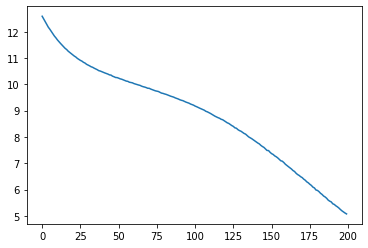

In [40]:
np_losses = [x.detach().numpy() for x in losses]
plt.plot(range(epochs), np_losses)

In [41]:
with t.no_grad():
    y_val = model(cat_test, con_test)
    loss = t.sqrt(criertion(y_val, y_test))

loss

tensor(5.0190)

In [50]:
for i in range(10):
    print("Predicted value {0:8.4f}, Actual Value {1:8.4f}, difference {2:8.2f}".format(y_val[i].item(), y_test[i].item(), y_test[i].item()-y_val[i].item()))

Predicted value   3.6550, Actual Value   2.9000, difference    -0.76
Predicted value  19.0640, Actual Value   5.7000, difference   -13.36
Predicted value   5.1545, Actual Value   7.7000, difference     2.55
Predicted value  11.7849, Actual Value  12.5000, difference     0.72
Predicted value   0.6768, Actual Value   4.1000, difference     3.42
Predicted value   0.5922, Actual Value   5.3000, difference     4.71
Predicted value  -0.5598, Actual Value   3.7000, difference     4.26
Predicted value  15.2125, Actual Value  14.5000, difference    -0.71
Predicted value   1.2794, Actual Value   5.7000, difference     4.42
Predicted value   9.0388, Actual Value  10.1000, difference     1.06


In [51]:
#saving the model
t.save(model.state_dict(), 'TaxiModel_ganesh.pt')